### 사용패키지 import

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Image 읽어와서 확인하기

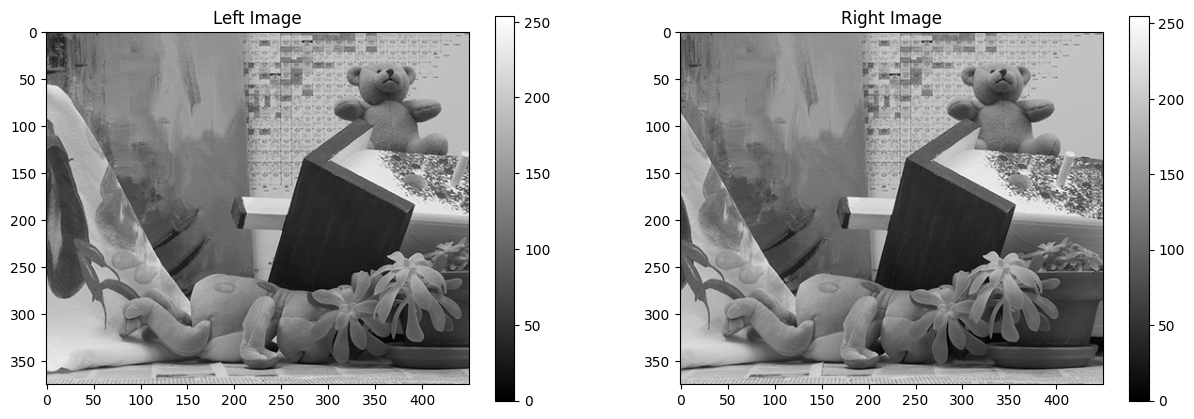

In [14]:
left_path = './data/left.png'
right_path = './data/right.png'
numDisparities = 48
blockSize = 25

imgL = cv2.imread(left_path)
imgR = cv2.imread(right_path)


imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(imgL_gray, cmap='gray')
plt.colorbar()
plt.title('Left Image')

plt.subplot(1, 2, 2)
plt.imshow(imgR_gray, cmap='gray')
plt.colorbar()
plt.title('Right Image')

plt.show()

### method(SAD, SSD, NCC) 각각의 disparity map 생성하기

In [15]:
def disparity_map_create(left, right, blockSize, numDisparities, method):
    disparity_map = np.zeros_like(left, dtype=np.float64)
    half_block = blockSize // 2
    height, width = left.shape
    for y in tqdm(range(half_block, height - half_block), desc = f"{method} in process"):
        for x in range(half_block + numDisparities, width - half_block):
            tmp_cost = np.inf if method in ['SAD', 'SSD'] else -np.inf
            left_block = left[y - half_block : y + half_block + 1, x - half_block : x + half_block + 1]
            for d in range(numDisparities):
                cost = 0
                if x - d - half_block >= 0:
                    right_block = right[y - half_block : y + half_block + 1, x - d - half_block : x - d + half_block + 1]
                    if method == 'SAD':
                        cost = np.sum(np.abs(left_block-right_block))
                        if cost < tmp_cost:
                            tmp_cost = cost
                            best_disparity = d
                    elif method == 'SSD':
                        cost = np.sum((left_block - right_block)**2)
                        if cost < tmp_cost:
                            tmp_cost = cost
                            best_disparity = d
                    elif method == 'NCC':
                        numerator = np.sum(left_block*right_block)
                        denominator = np.sqrt(np.sum(left_block**2)*np.sum(right_block**2))
                        if denominator != 0:
                            cost = numerator / denominator
                            if cost > tmp_cost:
                                tmp_cost = cost
                                best_disparity = d

            disparity_map[y, x] = best_disparity
    return disparity_map

### 이미지를 numpy 배열로 변환

In [16]:
left = np.array(imgL_gray, dtype=np.float64)
right = np.array(imgR_gray, dtype=np.float64)

### 위의 disparity_map_create를 통해서 각각의 disparity_map 생성

In [17]:
raw_sad = disparity_map_create(left, right, blockSize, numDisparities, 'SAD')
raw_ssd = disparity_map_create(left, right, blockSize, numDisparities, 'SSD')
raw_ncc = disparity_map_create(left, right, blockSize, numDisparities, 'NCC')

NCC in process: 100%|██████████| 351/351 [02:14<00:00,  2.61it/s]


### Built-In 과는 어떤 차이가 있을지 궁금하여 Built-In으로도 disparity map 생성

In [18]:
imgL_built = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
imgR_built = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
stereo = cv2.StereoBM.create(numDisparities, blockSize) 
disparity = stereo.compute(imgL_built,imgR_built)
scale_factor = disparity.max()

### 동일한 colorbar scale를 가지도록 normalization 함수 구현

In [19]:
def normalization(disparity_map, scale_factor):
    min_disp = disparity_map.min()
    max_disp = disparity_map.max()
    disparity_map = (disparity_map - min_disp) / (max_disp - min_disp) * scale_factor
    return disparity_map

### 각각의 disparity_map에 normalization 적용하기

In [20]:
norm_sad = normalization(raw_sad, scale_factor)
norm_ssd = normalization(raw_ssd, scale_factor)
norm_ncc = normalization(raw_ncc, scale_factor)

### 위에서 구한 3가지 방법과 built-in을 시각화

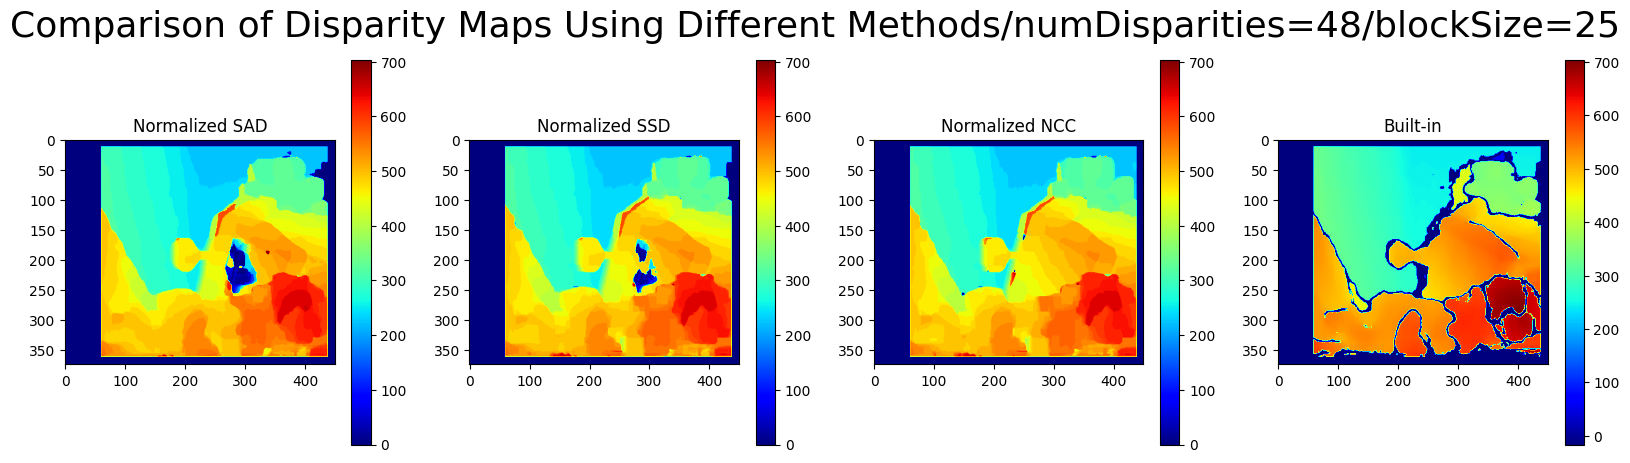

In [21]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(norm_sad, cmap='jet')
plt.colorbar()
plt.title('Normalized SAD')

plt.subplot(1, 4, 2)
plt.imshow(norm_ssd, cmap='jet')
plt.colorbar()
plt.title('Normalized SSD')

plt.subplot(1, 4, 3)
plt.imshow(norm_ncc, cmap='jet')
plt.colorbar()
plt.title('Normalized NCC')

plt.subplot(1, 4, 4)
plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title('Built-in')

plt.suptitle(f'Comparison of Disparity Maps Using Different Methods/numDisparities={numDisparities}/blockSize={blockSize}', fontsize=26)
plt.show()